In [14]:
from ctapipe.io.eventsourcefactory import EventSourceFactory
from ctapipe.calib import CameraCalibrator
from ctapipe.image.hillas import hillas_parameters
from ctapipe.image.cleaning import tailcuts_clean
import pandas as pd
import fact.io
import pyhessio
import numpy as np
import matplotlib.pyplot as plt
from ctapipe.visualization import CameraDisplay
%matplotlib inline

In [25]:
names_to_id = {'LSTCam': 1, 'NectarCam': 2, 'FlashCam': 3, 'DigiCam': 4, 'CHEC': 5}
types_to_id = {'LST': 1, 'MST': 2, 'SST': 3}
allowed_cameras = ['LSTCam', 'NectarCam', 'DigiCam']


cleaning_level = {
                    'ASTRICam': (5, 7),  # (5, 10)?
                    'FlashCam': (12, 15),
                    'LSTCam': (5, 10),  # ?? (3, 6) for Abelardo...
                    # ASWG Zeuthen talk by Abelardo Moralejo:
                    'NectarCam': (4, 8),
                    # "FlashCam": (4, 8),  # there is some scaling missing?
                    'DigiCam': (3, 6),
                    'CHEC': (2, 4),
                    'SCTCam': (1.5, 3)
                    }


In [26]:
n_events = 5
event_source = EventSourceFactory.produce(
    input_url='../data/raw/gamma_20deg_0deg_run6911___cta-prod3-merged_desert-2150m-Paranal-3HB89-NGFD.simtel.gz',
    max_events=n_events,
)

calibrator = CameraCalibrator(
    event_source=event_source,
    r1_product='HESSIOR1Calibrator',
)


In [28]:
for event in event_source:
    print(event.r0.obs_id, event.r0.event_id)
    
# calibrator.calibrate(event)

6911 206
6911 1405
6911 1602
6911 10204
6911 12202


In [18]:
def plot_event(event):
    plt.figure(figsize=(20, 20))
    plt.suptitle("EVENT {}".format(event.r0.event_id))

    cams = [event.inst.subarray.tels[i].camera for i in event.r0.tels_with_data]
    cams = [c for c in cams if c.cam_id in allowed_cameras]
    n_tels = len(cams)
    print(f'there are {n_tels} telescopes in the event')

    p = 1
    for telescope_id, dl1 in event.dl1.tel.items():
        camera = event.inst.subarray.tels[telescope_id].camera
        if camera.cam_id not in allowed_cameras:
            continue

        nn = int(np.ceil(np.sqrt(n_tels)))
        ax = plt.subplot(nn, nn, p)
        p +=1

        telescope_type_name = event.inst.subarray.tels[telescope_id].optics.tel_type
        picture_thresh, boundary_thresh = cleaning_level[camera.cam_id]
        mask = tailcuts_clean(camera, dl1.image[0], boundary_thresh=boundary_thresh, picture_thresh=picture_thresh)

        if mask.sum() < 3:  # only two pixel remaining. No luck anyways.
            continue

        hillas_params = hillas_parameters(
            camera[mask],
            dl1.image[0, mask],
            container=False
        )

        disp = CameraDisplay(camera, ax=ax, title="CT{0}".format(telescope_id))
        disp.pixels.set_antialiaseds(False)
        disp.autoupdate = False
        disp.add_colorbar()

        # Show the camera image and overlay Hillas ellipse and clean pixels
        disp.image = dl1.image[0]
        disp.cmap = 'PuOr'
        disp.highlight_pixels(mask, color='black')
        disp.overlay_moments(hillas_params, color='cyan', linewidth=3)        

there are 9 telescopes in the event


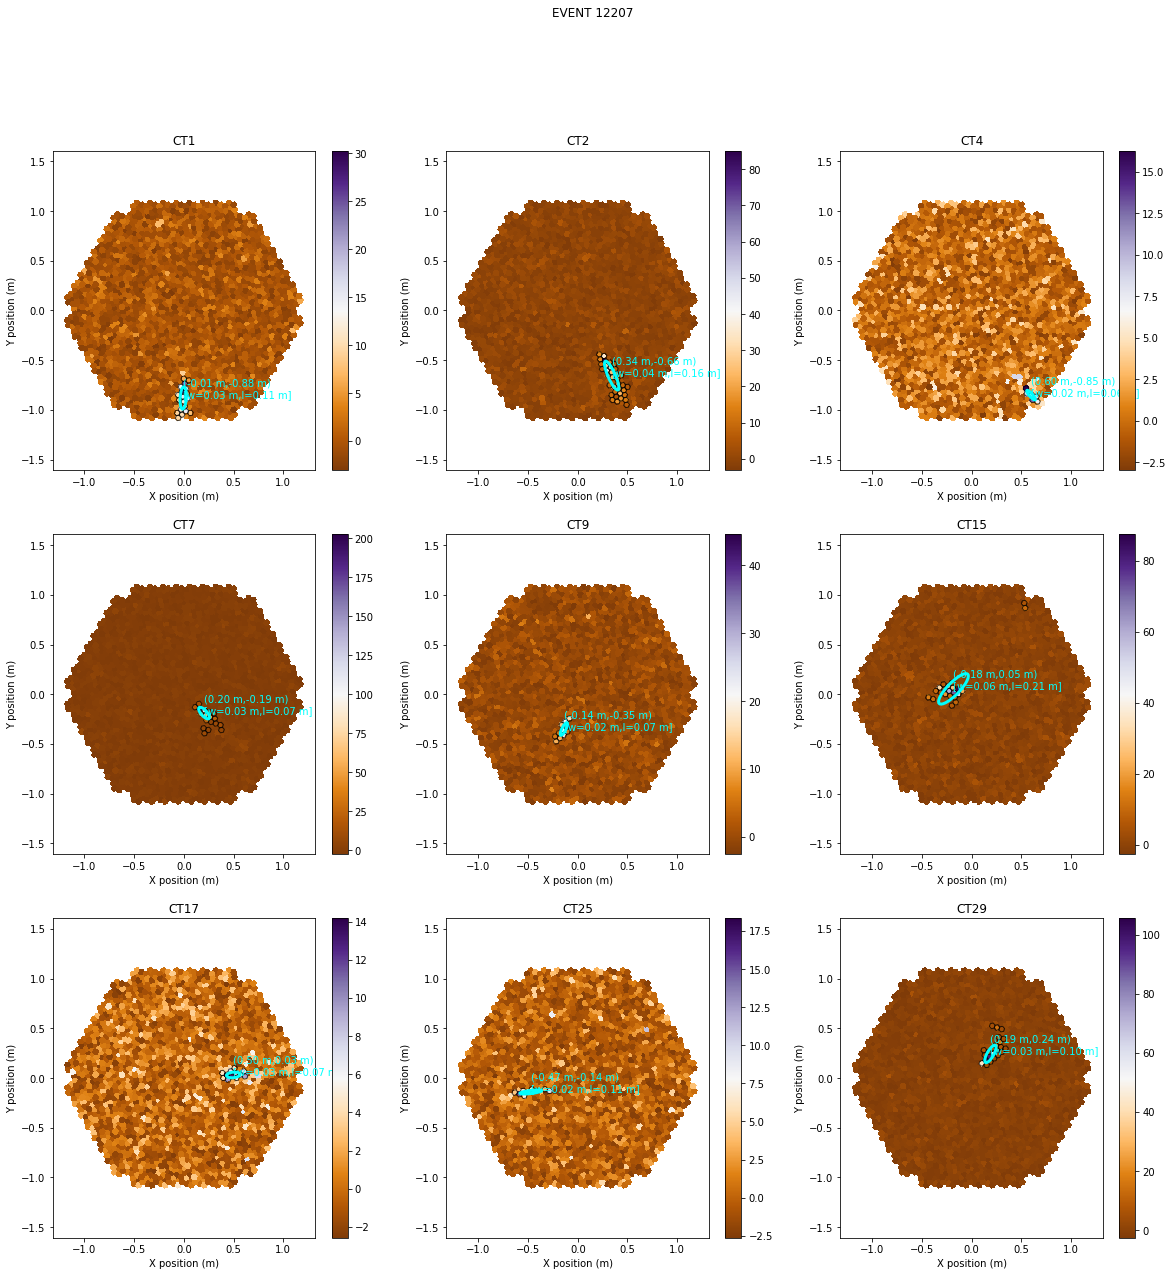

In [20]:
plot_event(event)